## EVALUATION NOTEBOOK

### Deep chroma

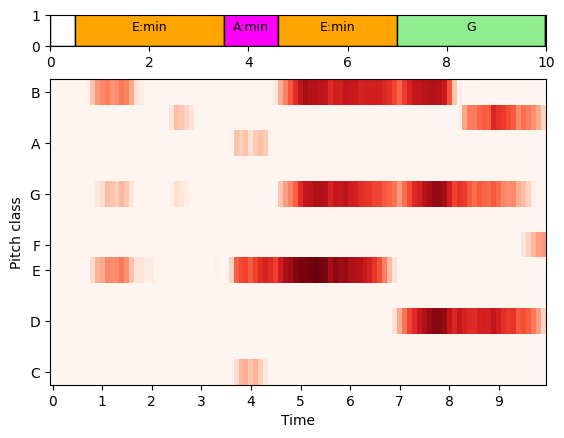

In [4]:
import librosa
import numpy as np
import utils
import matplotlib.pyplot as plt
from scipy.fftpack import dct,idct
import dataloader
import librosa.display
import features


dset = "beatles"
track_id = "0111" 

## Boys: 0105 -> blurry bass note  Tuning?
## Anna: 0103 

dataset = dataloader.Dataloader(dset,"/home/max/ET-TI/Masterarbeit/chord-recognition/mirdata","none")
audiopath, annotationpath = dataset[track_id] 
chroma_dcp = features.deepChroma(audiopath,1)
t_chroma = utils.timeVector(chroma_dcp.shape[1],hop_length=2205)
gt = utils.loadChordAnnotations(annotationpath)
fig,ax = plt.subplots(2,1,height_ratios=(1,10))
utils.plotChordAnnotations(ax[0],gt[0],gt[1],(0,10))
utils.plotChromagram(ax[1],t_chroma,chroma_dcp,(0,10))


### CQT and pitchgram analysis

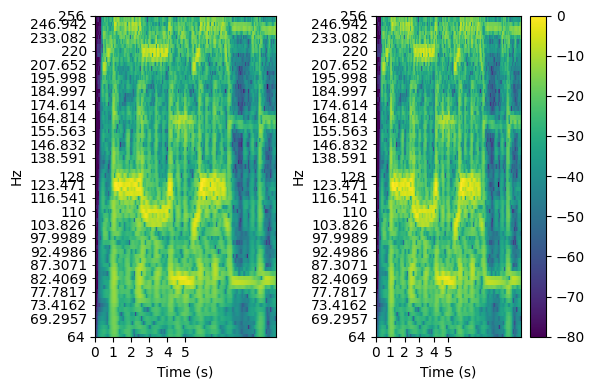

In [8]:
import librosa
import numpy as np
import utils
import matplotlib.pyplot as plt
from scipy.fftpack import dct,idct
import dataloader
import librosa.display

dset = "beatles"
track_id = "0105" 

## Boys: 0105 -> blurry bass note  Tuning?
## Anna: 0103 

dataset = dataloader.Dataloader(dset,"/home/max/ET-TI/Masterarbeit/chord-recognition/mirdata","none")
audiopath, annotationpath = dataset[track_id] 
sig = utils.loadAudiofile(audiopath,duration=10)
gt = utils.loadChordAnnotations(annotationpath)

####### tuned CQT ############
midi_start = 24
octaves = 7
cqt_params = {"sr":22050,"bins_per_octave":36,"hop_length":1024,"fmin":librosa.midi_to_hz(midi_start)}

estimated_tuning = librosa.estimate_tuning(y=sig,sr=22050,bins_per_octave=36)
C = np.abs(librosa.vqt(sig,filter_scale=1,tuning=estimated_tuning,gamma=0,n_bins=octaves*36, **cqt_params))
fig,(ax0,ax1) = plt.subplots(1,2,figsize=(6,4))
img = librosa.display.specshow(librosa.amplitude_to_db(C,ref=np.max),
                         ax=ax0,y_axis="cqt_hz",x_axis="s",cmap="viridis",**cqt_params)
img = librosa.display.specshow(librosa.amplitude_to_db(C,ref=np.max),
                         ax=ax1,y_axis="cqt_hz",x_axis="s",cmap="viridis",**cqt_params)
ax1.set_ylim(librosa.midi_to_hz(45),librosa.midi_to_hz(75))
for ax in [ax0,ax1]:
    ax.set_xlim(0,10)
    ax.set_xticks([0,1,2,3,4,5])
    ax.set_ylim(64,256)
fig.colorbar(img);
fig.tight_layout()

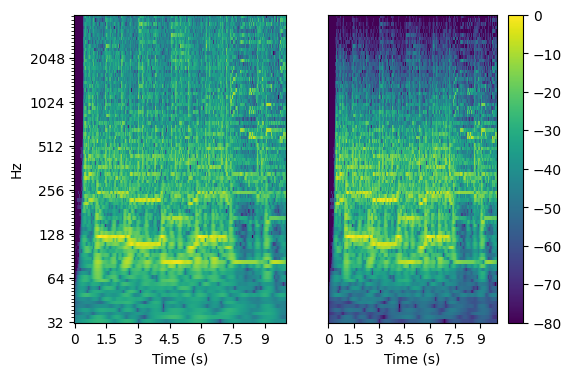

In [6]:
## apply gaussian window function to deemphasize low frequent hum and overtones 
## centered around C4 +/- 15 note 
window=True
pitchgram_cqt = np.zeros((12*octaves,C.shape[1]),dtype=float)
pitchgram_cqt_windowed = np.zeros((12*octaves,C.shape[1]),dtype=float)
# pitchgram window function
for note in range(midi_start, midi_start+12*octaves):
    # weight and pick every third amplitude value
    pitchgram_cqt[note - midi_start,:] =  C[(note-midi_start)*3, :]
    pitchgram_cqt_windowed[note - midi_start,:] = np.exp(-(note-60)**2 / (2*15**2)) * C[(note-midi_start)*3,:] 
pitchgram_energy = pitchgram_cqt ** 2

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(6,4))
pitchgram_params = cqt_params
pitchgram_params["bins_per_octave"] = 12
librosa.display.specshow(librosa.amplitude_to_db(pitchgram_cqt,ref=np.max),
                         ax=ax0,y_axis="cqt_hz",x_axis="s",cmap="viridis",**pitchgram_params)
img = librosa.display.specshow(librosa.amplitude_to_db(pitchgram_cqt_windowed,ref=np.max),
                         ax=ax1,x_axis="s",cmap="viridis",**pitchgram_params)
fig.colorbar(img);

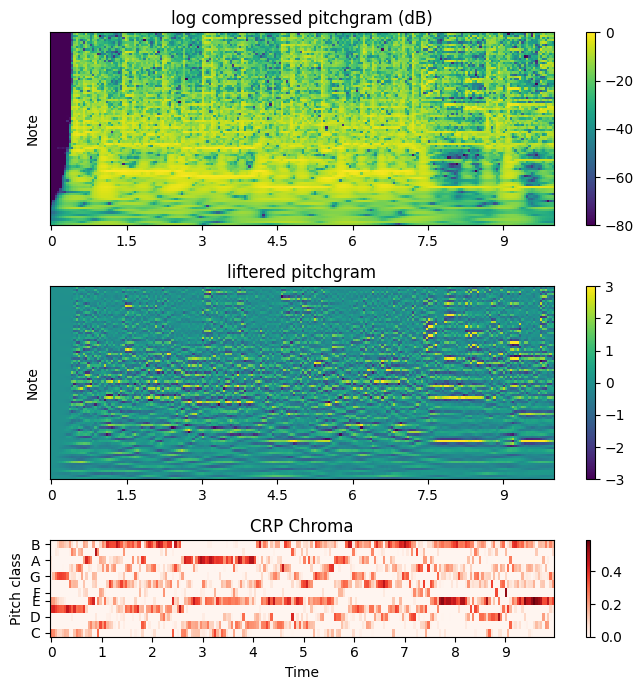

In [7]:
### Logarithmic Compression and Liftering 
eta = 100
nCRP = 33
if True:
    pitchgram_log = np.log(eta * pitchgram_energy + 1)
else:
    pitchgram_log = pitchgram_cqt
vLogDCT = dct(pitchgram_log, norm='ortho', axis=0);  
vLogDCT[:nCRP,:] = 0 
vLogDCT[nCRP,:] = 0.5 * vLogDCT[nCRP,:]
pitchgram_lift = idct(vLogDCT, norm='ortho', axis=0)

# pitch folding
crp = pitchgram_lift.reshape(octaves,12,-1) 
crp = np.sum(crp, axis=0)
crp = np.clip(crp,0,None) # clip negative values
crp = crp /np.sum(np.abs(crp) + np.finfo(float).tiny, axis=0) # apply manhattan norm

t_chroma = utils.timeVector(crp.shape[1],hop_length=cqt_params["hop_length"])
fig,(ax0,ax1,ax2) = plt.subplots(3,1,figsize=(7,7),height_ratios=(2,2,1))
img = librosa.display.specshow(librosa.amplitude_to_db(pitchgram_log,ref=np.max),
                         ax=ax0,x_axis="s",y_axis="cqt_note",cmap="viridis",**pitchgram_params)
fig.colorbar(img)
ax0.set_title("log compressed pitchgram (dB)")
img = librosa.display.specshow(pitchgram_lift,
                         ax=ax1,x_axis="s",y_axis="cqt_note",cmap="viridis",**pitchgram_params,vmin=-3,vmax=3)
fig.colorbar(img)
ax1.set_title("liftered pitchgram")
for ax in [ax0,ax1]:
    ax.set_xlabel("")
img = utils.plotChromagram(ax2,t_chroma,crp)

ax2.set_title("CRP Chroma")
fig.colorbar(img);
fig.tight_layout()

### Transsprition Results

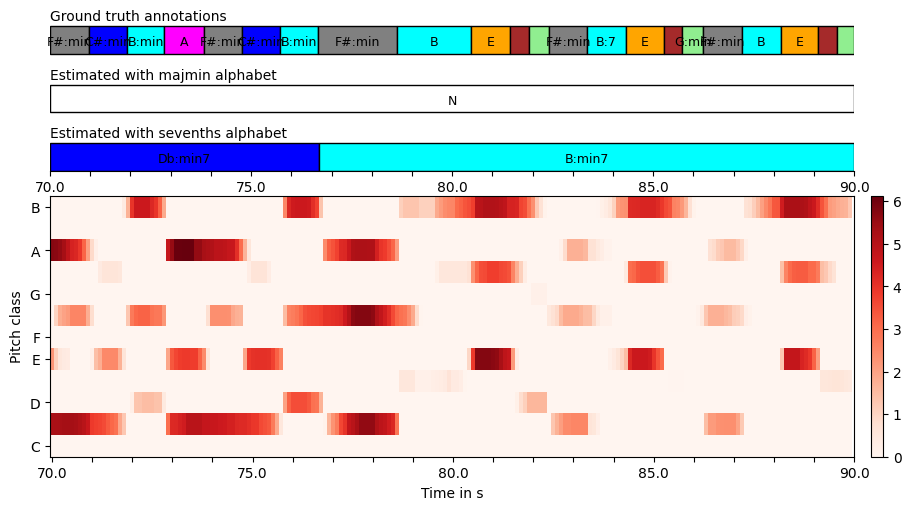

In [1]:
import matplotlib.pyplot as plt
from visualization import visualizationApp
%matplotlib inline
visualizationApp("/home/max/ET-TI/Masterarbeit/chord-recognition/results");
plt.ioff(); # interactive mode off

Wilcoxon test for paired samples
Majmin: z=-2.2, p=0.025, r=0.12
Sevenths: z=-0.4, p=0.687, r=0.02


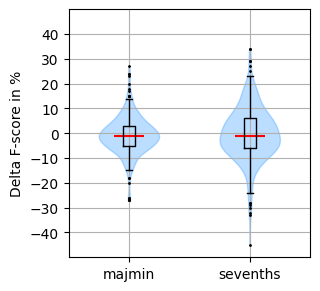

In [1]:
from visualization import load_results
from dataloader import OUTLIERS
from scipy import stats
import matplotlib.pyplot as plt
import utils
import numpy as np
plt.ion() # interactive mode on
median,datasets = load_results("/home/max/ET-TI/Masterarbeit/chord-recognition/results/median_drums.hdf5")
cpss,datasets = load_results("/home/max/ET-TI/Masterarbeit/chord-recognition/results/cpss.hdf5")
delta_f = [100*(x.majmin_f - y.majmin_f) for x,y in zip(cpss,median) if x.name not in OUTLIERS]
delta_f_sevenths = [100*(x.sevenths_f - y.sevenths_f) for x,y in zip(cpss,median) if x.name not in OUTLIERS]
fig, ax = plt.subplots(figsize=(3, 2.8))
utils.create_violinplot(ax,[delta_f,delta_f_sevenths],["majmin","sevenths"],"DodgerBlue")
fig.tight_layout(pad=0.1)
ax.set_yticks(np.arange(-40,50,10))
ax.set_ylim(-50,50)
ax.set_ylabel("Delta F-score in %");
res = stats.wilcoxon(delta_f,method='approx')
res_sevenths = stats.wilcoxon(delta_f_sevenths,method='approx')

print("Wilcoxon test for paired samples")
print(f"Majmin: z={res.zstatistic:0.1f}, p={res.pvalue:0.3f}, r={np.abs(res.zstatistic) / np.sqrt(len(delta_f)):0.2f}")
print(f"Sevenths: z={res_sevenths.zstatistic:0.1f}, p={res_sevenths.pvalue:0.3f}, r={np.abs(res_sevenths.zstatistic) / np.sqrt(len(delta_f)):0.2f}")


### Comparison of results between rp and median filtering and the deep chroma processor

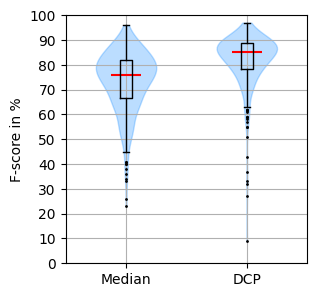

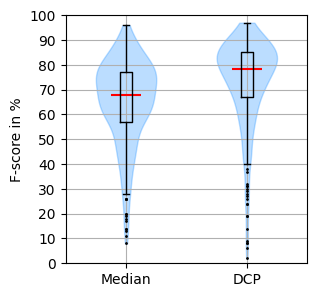

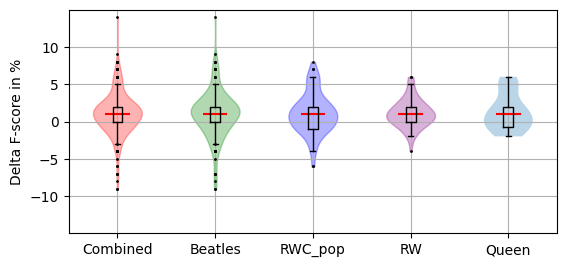

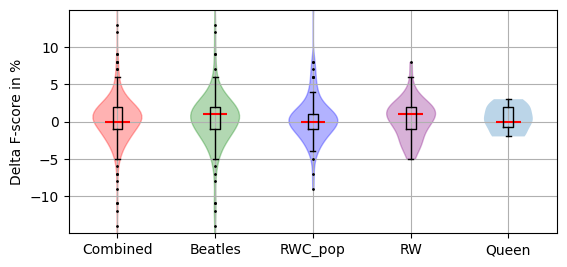

In [1]:
from visualization import load_results
from dataloader import OUTLIERS
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import utils

results_median,datasets = load_results("/home/max/ET-TI/Masterarbeit/chord-recognition/results/median_none.hdf5")
results_rp,_ = load_results("/home/max/ET-TI/Masterarbeit/chord-recognition/results/rp_none.hdf5")
results_dcp,_ = load_results("/home/max/ET-TI/Masterarbeit/chord-recognition/results/dcp_none.hdf5")

results_median = [x for x in results_median if x.name not in OUTLIERS]
results_rp = [x for x in results_rp if x.name not in OUTLIERS]
               
majmin_dcp = [100*x.majmin_f for x in results_dcp]
sevenths_dcp = [100*x.sevenths_f for x in results_dcp]

comparison_median_dcp = [(x,y) for x,y in zip(results_median,results_dcp) if x.majmin_f > y.majmin_f ]
# for data in comparison_median_dcp:
#     print(f"{data[0].name} -{data[0].track_id} - MEDIAN: {data[0].majmin_f} , DCP: {data[1].majmin_f}")

majmin_f_median = [100*x.majmin_f for x in results_median]
sevenths_f_median = [100*x.sevenths_f for x in results_median]
majmin_f_rp = [100*x.majmin_f for x in results_rp]
sevenths_f_rp = [100*x.sevenths_f for x in results_rp]

fig, ax = plt.subplots(figsize=(3, 2.8))
utils.create_violinplot(ax,[majmin_f_median,majmin_dcp],["Median","DCP"],"DodgerBlue")
fig.tight_layout(pad=0.1)
fig.savefig("/home/max/ET-TI/Masterarbeit/latex/figures/median_rp_majmin_result.png")

fig, ax = plt.subplots(figsize=(3, 2.8)) 
utils.create_violinplot(ax,[sevenths_f_median,sevenths_dcp],["Median","DCP"],"DodgerBlue")
fig.tight_layout(pad=0.1)
fig.savefig("/home/max/ET-TI/Masterarbeit/latex/figures/median_rp_sevenths_result.png")

majmin_f = [100*x.majmin_f for x in results_median if x.name not in OUTLIERS]
majmin_f_rp = [100*x.majmin_f for x in results_rp if x.name not in OUTLIERS]
beatles_f = [100*x.majmin_f for x in results_median if x.name not in OUTLIERS and x.dataset == "beatles"]
beatles_f_rp = [100*x.majmin_f for x in results_rp if x.name not in OUTLIERS and x.dataset == "beatles"]
rwc_f = [100*x.majmin_f for x in results_median if x.name not in OUTLIERS and x.dataset == "rwc_pop"]
rwc_f_rp = [100*x.majmin_f for x in results_rp if x.name not in OUTLIERS and x.dataset == "rwc_pop"]
rw_f = [100*x.majmin_f for x in results_median if x.name not in OUTLIERS and x.dataset == "rw"]
rw_f_rp = [100*x.majmin_f for x in results_rp if x.name not in OUTLIERS and x.dataset == "rw"]
queen_f = [100*x.majmin_f for x in results_median if x.name not in OUTLIERS and x.dataset == "queen"]
queen_f_rp = [100*x.majmin_f for x in results_rp if x.name not in OUTLIERS and x.dataset == "queen"]

majmin_f_sev = [100*x.sevenths_f for x in results_median if x.name not in OUTLIERS]
majmin_f_rp_sev = [100*x.sevenths_f for x in results_rp if x.name not in OUTLIERS]
beatles_f_sev = [100*x.sevenths_f for x in results_median if x.name not in OUTLIERS and x.dataset == "beatles"]
beatles_f_rp_sev = [100*x.sevenths_f for x in results_rp if x.name not in OUTLIERS and x.dataset == "beatles"]
rwc_f_sev = [100*x.sevenths_f for x in results_median if x.name not in OUTLIERS and x.dataset == "rwc_pop"]
rwc_f_rp_sev = [100*x.sevenths_f for x in results_rp if x.name not in OUTLIERS and x.dataset == "rwc_pop"]
rw_f_sev = [100*x.sevenths_f for x in results_median if x.name not in OUTLIERS and x.dataset == "rw"]
rw_f_rp_sev = [100*x.sevenths_f for x in results_rp if x.name not in OUTLIERS and x.dataset == "rw"]
queen_f_sev = [100*x.sevenths_f for x in results_median if x.name not in OUTLIERS and x.dataset == "queen"]
queen_f_rp_sev = [100*x.sevenths_f for x in results_rp if x.name not in OUTLIERS and x.dataset == "queen"]

delta_f = [x-y for x,y in zip(majmin_f_rp,majmin_f)]
beatles_delta = [x-y for x,y in zip(beatles_f_rp,beatles_f)]
rwc_delta = [x-y for x,y in zip(rwc_f_rp,rwc_f)]
rw_delta = [x-y for x,y in zip(rw_f_rp,rw_f)]
queen_delta = [x-y for x,y in zip(queen_f_rp,queen_f)]
data = [delta_f,beatles_delta,rwc_delta,rw_delta,queen_delta]
xlabels = ["Combined","Beatles", "RWC_pop","RW","Queen"]

fig,ax =fig, ax = plt.subplots(figsize=(5.5, 2.5))
violin_parts = ax.violinplot(data,showmeans=False, showmedians=True,
        showextrema=False)
violin_parts["cmedians"].set_color("red")
for x,color in zip(violin_parts["bodies"],['r','g','b','purple']):
    x.set_color(color)
bplot_parts = ax.boxplot(data,
            showfliers=True,medianprops=dict(linestyle=None,linewidth=0),
            flierprops=dict(markerfacecolor='k', marker='o',markersize=1),
            widths=0.1)
ax.set_yticks(np.arange(-10,15,5))
ax.set_ylim(-15,15)
ax.set_ylabel("Delta F-score in %")
ax.set_xticks(np.arange(1, len(xlabels) + 1), labels=xlabels)
ax.set_xlim(0.5, len(xlabels) + 0.5);
ax.grid("on")
fig.tight_layout(pad=0.1)
fig.savefig("/home/max/ET-TI/Masterarbeit/latex/figures/median_rp_dataset.png")


delta_f = [x-y for x,y in zip(majmin_f_rp_sev,majmin_f_sev)]
beatles_delta = [x-y for x,y in zip(beatles_f_rp_sev,beatles_f_sev)]
rwc_delta = [x-y for x,y in zip(rwc_f_rp_sev,rwc_f_sev)]
rw_delta = [x-y for x,y in zip(rw_f_rp_sev,rw_f_sev)]
queen_delta = [x-y for x,y in zip(queen_f_rp_sev,queen_f_sev)]
data = [delta_f,beatles_delta,rwc_delta,rw_delta,queen_delta]
xlabels = ["Combined","Beatles", "RWC_pop","RW","Queen"]

fig,ax =fig, ax = plt.subplots(figsize=(5.5, 2.5))
violin_parts = ax.violinplot(data,showmeans=False, showmedians=True,
        showextrema=False)
violin_parts["cmedians"].set_color("red")
for x,color in zip(violin_parts["bodies"],['r','g','b','purple']):
    x.set_color(color)
bplot_parts = ax.boxplot(data,
            showfliers=True,medianprops=dict(linestyle=None,linewidth=0),
            flierprops=dict(markerfacecolor='k', marker='o',markersize=1),
            widths=0.1)
ax.set_yticks(np.arange(-10,15,5))
ax.set_ylim(-15,15)
ax.set_ylabel("Delta F-score in %")
ax.set_xticks(np.arange(1, len(xlabels) + 1), labels=xlabels)
ax.set_xlim(0.5, len(xlabels) + 0.5);
ax.grid("on")
fig.tight_layout(pad=0.1)
# fig.savefig("/home/max/ET-TI/Masterarbeit/latex/figures/median_rp_dataset_sevenths.png")


# Wilcoxon test
A Wilcoxon signed-rank test was calculated to examine the effect of using a recurrency plot to smooth the chromagram instead of horizontal median filters. The transcription result measured are compared with the F-scores using the majmin alphabet. The distribution of the paired differences was symmetrical following visual inspection of the histogram. There was a statistically significant increase in F-scores (Mdn = 77.0%) using the recurrency plot compared to the use of median filters (Mdn = 75.5%), t = 12175.0, p < .001

Wilcoxon test for paired samples
Majmin: z=-7.3, p=0.000, r=0.39
Sevenths: z=-2.0, p=0.045, r=0.11


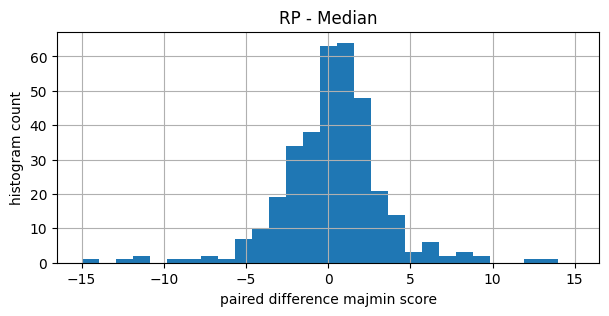

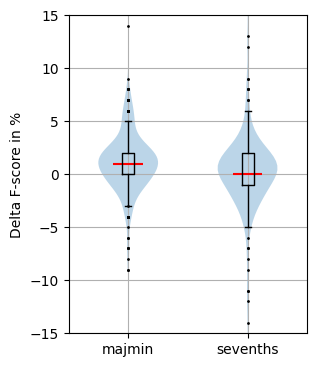

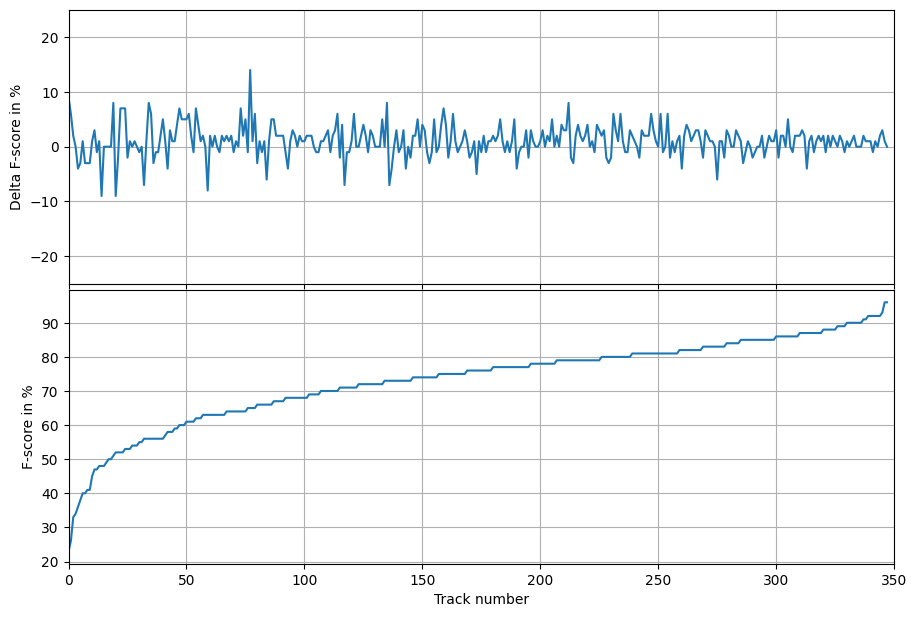

In [28]:
diff = [x - y for x,y in zip(majmin_f_rp, majmin_f_median)]
diff_sorted = sorted([(y,x-y) for x,y in zip(majmin_f_rp, majmin_f_median)],key=lambda x:x[0])

diff_sevenths = [x - y for x,y in zip(sevenths_f_rp,sevenths_f_median)]
fig,ax = plt.subplots(figsize=(7,3))
ax.grid(True)
ax.hist(diff_sevenths,bins=np.linspace(-15,15,30))
ax.set_ylabel("histogram count")
ax.set_xlabel("paired difference majmin score")
ax.set_title("RP - Median")
res = stats.wilcoxon(diff,method='approx')
res_sevenths = stats.wilcoxon(diff_sevenths,method='approx')

print("Wilcoxon test for paired samples")
print(f"Majmin: z={res.zstatistic:0.1f}, p={res.pvalue:0.3f}, r={np.abs(res.zstatistic) / np.sqrt(len(diff)):0.2f}")
print(f"Sevenths: z={res_sevenths.zstatistic:0.1f}, p={res_sevenths.pvalue:0.3f}, r={np.abs(res_sevenths.zstatistic) / np.sqrt(len(diff)):0.2f}")


fig, ax1 = plt.subplots(figsize=(3, 3.5))
parts = ax1.violinplot([diff,diff_sevenths],showmeans=False, showmedians=True,
        showextrema=False)
bplot = ax1.boxplot([diff,diff_sevenths],widths=0.1,showfliers=True,medianprops=dict(linestyle=None,linewidth=0),flierprops=dict(markerfacecolor='k', marker='o',markersize=1))
parts["cmedians"].set_color("red")
xlabels = ["majmin","sevenths"]
ax1.set_yticks(np.arange(-20,30,5))
ax1.set_ylim(-15,15)
ax1.set_ylabel("Delta F-score in %")
ax1.set_xticks(np.arange(1, len(xlabels) + 1), labels=xlabels)
ax1.set_xlim(0.5, len(xlabels) + 0.5);
ax1.grid("on")
fig.tight_layout(pad=0.1)
fig.savefig("/home/max/ET-TI/Masterarbeit/latex/figures/median_rp_delta.png")

# sort results by f-scores in ascending order
majmin_sorted = [x[0] for x in diff_sorted]
delta = [x[1] for x in diff_sorted]
fig,(ax0,ax1) = plt.subplots(2,1,figsize=(9,6),sharex=True)
ax0.plot(delta)
ax0.grid("on")
ax0.set_ylim(-25,25)
ax0.set_ylabel("Delta F-score in %")
ax1.plot(majmin_sorted)
ax1.set_ylabel("F-score in %")
ax1.set_xlim(0,350)
ax1.set_xlabel("Track number")
ax1.grid("on")
fig.tight_layout(pad=0.1)
fig.savefig("/home/max/ET-TI/Masterarbeit/latex/figures/median_rp_sorted_delta.png")


### Study on source separation

Majmin
Wilcoxon test for paired samples
comparison mix/no vocals: N=348, z=-1.9, p=0.054, r=0.10
comparison mix/no drums: N=348, z=-6.1, p=0.000, r=0.33
comparison mix/no vocals and drums: N=348, z=-6.4, p=0.000, r=0.34
comparison no drums / no drums and no vocals: N=348, z=-2.2, p=0.028, r=0.12


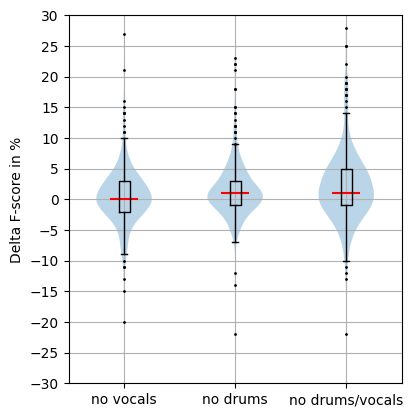

In [29]:
results = {}
for source_sep in ["none","vocals","drums","both"]:
        results[source_sep], datasets = load_results(f"/home/max/ET-TI/Masterarbeit/results/median_{source_sep}")

results_rp,_ = load_results("/home/max/ET-TI/Masterarbeit/results/rp_none")
# list of tracks that should be excluded due to issues with the annotations / or lack of harmonic content
outliers = ['03_-_Anna_(Go_To_Him)', # tuning issues
            '10_-_Lovely_Rita', # tuning issues
            'CD1_-_05_-_Wild_Honey_Pie', # little harmonic content
            'CD1_-_06_-_The_Continuing_Story_of_Bungalow_Bill', # faulty audio or annotations
            'CD2_-_12_-_Revolution_9',  # little harmonic content
            '08_-_Within_You_Without_You', # leslie effect on piano => bad chroma
            '02 Another One Bites The Dust', # little harmonic content
            '16 We Will Rock You', # little harmonic content
            "Stalker's Day Off (I've Been Hanging Around)", # faulty audio / issues with annotations
            'Stand Your Ground'  # faulty audio / issues with annotations
]

majmin_none = [100*x.majmin_f for x in results["none"] if x.name not in outliers]
majmin_rp = [100*x.majmin_f for x in results_rp if x.name not in outliers]
majmin_vocals = [100*x.majmin_f for x in results["vocals"] if x.name not in outliers]
majmin_drums = [100*x.majmin_f for x in results["drums"] if x.name not in outliers]
majmin_both = [100*x.majmin_f for x in results["both"] if x.name not in outliers]
sevenths_none = [100*x.sevenths_f for x in results["none"] if x.name not in outliers]
sevenths_vocals = [100*x.sevenths_f for x in results["vocals"] if x.name not in outliers]
sevenths_drums = [100*x.sevenths_f for x in results["drums"] if x.name not in outliers]
sevenths_both = [100*x.sevenths_f for x in results["both"] if x.name not in outliers]

delta_median_rp = [x-y for x,y in zip(majmin_f_rp, majmin_f_median)]
delta_majmin_vocals = [y-x for x,y in zip(majmin_none,majmin_vocals)]
delta_majmin_drums = [y-x for x,y in zip(majmin_none,majmin_drums)]
delta_majmin_both = [y-x for x,y in zip(majmin_none,majmin_both)]

fig, ax1 = plt.subplots(figsize=(4, 4))
parts = ax1.violinplot([delta_majmin_vocals,delta_majmin_drums,delta_majmin_both],showmeans=False, showmedians=True,
        showextrema=False)
bplot = ax1.boxplot([delta_majmin_vocals,delta_majmin_drums,delta_majmin_both],
                    showfliers=True,medianprops=dict(linestyle=None,linewidth=0),
                    flierprops=dict(markerfacecolor='k', marker='o',markersize=1),
                    widths=0.1)
parts["cmedians"].set_color("red")
xlabels = ["no vocals","no drums","no drums/vocals"]
ax1.set_yticks(np.arange(-35,35,5))
ax1.set_ylim(-30,30)
ax1.set_ylabel("Delta F-score in %")
ax1.set_xticks(np.arange(1, len(xlabels) + 1), labels=xlabels)
ax1.set_xlim(0.5, len(xlabels) + 0.5);
ax1.grid("on")
fig.tight_layout(pad=0.1)
fig.savefig("/home/max/ET-TI/Masterarbeit/latex/figures/source_separation_majmin_result.png")

delta_drums_vocals = [y-x for x,y in zip(majmin_both,majmin_drums)]
print("Majmin")
res_v = stats.wilcoxon(delta_majmin_vocals,method='approx')
res_d = stats.wilcoxon(delta_majmin_drums,method='approx')
res_h = stats.wilcoxon(delta_majmin_both,method='approx')
res_dv = stats.wilcoxon(delta_drums_vocals,method='approx')

print("Wilcoxon test for paired samples")
print(f"comparison mix/no vocals: N={len(delta_majmin_vocals)}, z={res_v.zstatistic:0.1f}, p={res_v.pvalue:0.3f}, r={np.abs(res_v.zstatistic) / np.sqrt(len(delta_majmin_vocals)):0.2f}")
print(f"comparison mix/no drums: N={len(delta_majmin_vocals)}, z={res_d.zstatistic:0.1f}, p={res_d.pvalue:0.3f}, r={np.abs(res_d.zstatistic) / np.sqrt(len(delta_majmin_vocals)):0.2f}")
print(f"comparison mix/no vocals and drums: N={len(delta_majmin_vocals)}, z={res_h.zstatistic:0.1f}, p={res_h.pvalue:0.3f}, r={np.abs(res_h.zstatistic) / np.sqrt(len(delta_majmin_vocals)):0.2f}")
print(f"comparison no drums / no drums and no vocals: N={len(delta_majmin_vocals)}, z={res_dv.zstatistic:0.1f}, p={res_dv.pvalue:0.3f}, r={np.abs(res_dv.zstatistic) / np.sqrt(len(delta_majmin_vocals)):0.2f}")


Majmin: separation both
Wilcoxon test for paired samples
beatles: N=171 z=-1.3, p=0.187, r=0.10
median: 77.0 +- 12.0
rwc: N=98, z=-5.4, p=0.000, r=0.55
median: 78.5 +- 14.0
rw: N=61, z=-4.9, p=0.000, r=0.63
median: 81.0 +- 12.0
queen: N=18, z=-2.5, p=0.013, r=0.59
median: 74.5 +- 16.75


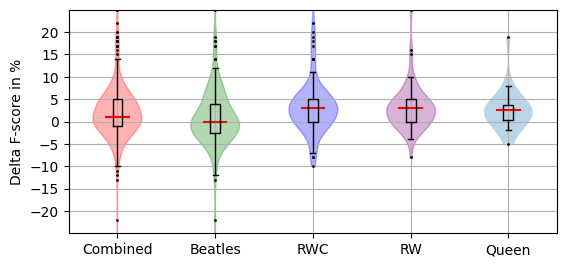

In [34]:
## Dataset specific eximination
separation_method = "both"

f_none = [100*x.majmin_f for x in results["none"] if x.name not in outliers]
beatles_f_none = [100*x.majmin_f for x in results["none"] if x.name not in outliers and x.dataset == "beatles"]
rwc_f_none = [100*x.majmin_f for x in results["none"] if x.name not in outliers and x.dataset == "rwc_pop"]
rw_f_none = [100*x.majmin_f for x in results["none"] if x.name not in outliers and x.dataset == "rw"]
queen_f_none = [100*x.majmin_f for x in results["none"] if x.name not in outliers and x.dataset == "queen"]

f_separated = [100*x.majmin_f for x in results[separation_method] if x.name not in outliers]
beatles_f = [100*x.majmin_f for x in results[separation_method] if x.name not in outliers and x.dataset == "beatles"]
rwc_f = [100*x.majmin_f for x in results[separation_method] if x.name not in outliers and x.dataset == "rwc_pop"]
rw_f = [100*x.majmin_f for x in results[separation_method] if x.name not in outliers and x.dataset == "rw"]
queen_f = [100*x.majmin_f for x in results[separation_method] if x.name not in outliers and x.dataset == "queen"]

delta = [x-y for x,y in zip(f_separated,f_none)]
beatles_delta = [x-y for x,y in zip(beatles_f,beatles_f_none)]
rwc_delta = [x-y for x,y in zip(rwc_f,rwc_f_none)]
rw_delta = [x-y for x,y in zip(rw_f,rw_f_none)]
queen_delta = [x-y for x,y in zip(queen_f,queen_f_none)]

fig, ax1 = plt.subplots(figsize=(5.5, 2.5))
parts = ax1.violinplot([delta,beatles_delta, rwc_delta, rw_delta, queen_delta],showmeans=False, showmedians=True,
        showextrema=False)
bplot = ax1.boxplot([delta,beatles_delta, rwc_delta, rw_delta, queen_delta],
                    showfliers=True,medianprops=dict(linestyle=None,linewidth=0),
                    flierprops=dict(markerfacecolor='k', marker='o',markersize=1),
                    widths=0.1)
parts["cmedians"].set_color("red")
for x,color in zip(parts["bodies"],['r','g','b','purple']):
    x.set_color(color)
xlabels = ["Combined","Beatles","RWC","RW","Queen"]
ax1.set_yticks(np.arange(-20,25,5))
ax1.set_ylim(-25,25)
ax1.set_ylabel("Delta F-score in %")
ax1.set_xticks(np.arange(1, len(xlabels) + 1), labels=xlabels)
ax1.set_xlim(0.5, len(xlabels) + 0.5);
ax1.grid("on")
fig.tight_layout(pad=0.1)


med_seg_sevenths = 100 * np.median(beatles_f)
iqr_seg_sevenths = 100 * np.subtract(*np.percentile(beatles_f, [75, 25]))

fig.savefig(f"/home/max/ET-TI/Masterarbeit/latex/figures/separation_{separation_method}_delta.png")
print(f"Majmin: separation {separation_method}")
res_beatles = stats.wilcoxon(beatles_delta,method='approx')
res_rwc = stats.wilcoxon(rwc_delta,method='approx')
res_rw = stats.wilcoxon(rw_delta,method='approx')
res_queen = stats.wilcoxon(queen_delta,method='approx')
print("Wilcoxon test for paired samples")
print(f"beatles: N={len(beatles_delta)} z={res_beatles.zstatistic:0.1f}, p={res_beatles.pvalue:0.3f}, r={np.abs(res_beatles.zstatistic) / np.sqrt(len(beatles_delta)):0.2f}")
print(f"median: {np.median(beatles_f)} +- {np.subtract(*np.percentile(beatles_f, [75, 25]))}")
print(f"rwc: N={len(rwc_delta)}, z={res_rwc.zstatistic:0.1f}, p={res_rwc.pvalue:0.3f}, r={np.abs(res_rwc.zstatistic) / np.sqrt(len(rwc_delta)):0.2f}")
print(f"median: {np.median(rwc_f)} +- {np.subtract(*np.percentile(rwc_f, [75, 25]))}")
print(f"rw: N={len(rw_delta)}, z={res_rw.zstatistic:0.1f}, p={res_rw.pvalue:0.3f}, r={np.abs(res_rw.zstatistic) / np.sqrt(len(rw_delta)):0.2f}")
print(f"median: {np.median(rw_f)} +- {np.subtract(*np.percentile(rw_f, [75, 25]))}")
print(f"queen: N={len(queen_delta)}, z={res_queen.zstatistic:0.1f}, p={res_queen.pvalue:0.3f}, r={np.abs(res_queen.zstatistic) / np.sqrt(len(queen_delta)):0.2f}")
print(f"median: {np.median(queen_f)} +- {np.subtract(*np.percentile(queen_f, [75, 25]))}")

#### Study on correlation vs inner product

In [4]:
from visualization import load_results
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

results_inner,_ = load_results("/home/max/ET-TI/Masterarbeit/chord-recognition/results/median_drums.hdf5")
results_corr,_ = load_results("/home/max/ET-TI/Masterarbeit/chord-recognition/results/correlation_median_drums.hdf5")
# list of tracks that should be excluded due to issues with the annotations / or lack of harmonic content
outliers = ['03_-_Anna_(Go_To_Him)', # tuning issues
            '10_-_Lovely_Rita', # tuning issues
            'CD1_-_05_-_Wild_Honey_Pie', # little harmonic content
            'CD1_-_06_-_The_Continuing_Story_of_Bungalow_Bill', # faulty audio or annotations
            'CD2_-_12_-_Revolution_9',  # little harmonic content
            '08_-_Within_You_Without_You', # leslie effect on piano => bad chroma
            '02 Another One Bites The Dust', # little harmonic content
            '16 We Will Rock You', # little harmonic content
            "Stalker's Day Off (I've Been Hanging Around)", # faulty audio / issues with annotations
            'Stand Your Ground'  # faulty audio / issues with annotations
]

majmin_inner = [100*x.majmin_f for x in results_inner if x.name not in outliers]
majmin_corr = [100*x.majmin_f for x in results_corr if x.name not in outliers]

sevenths_inner = [x for x in results_inner if x.name not in outliers]
sevenths_corr = [x for x in results_corr if x.name not in outliers]


f_none = [100*x.sevenths_f for x in results_inner if x.name not in outliers]
beatles_f_none = [100*x.sevenths_f for x in results_inner if x.name not in outliers and x.dataset == "beatles"]
rwc_f_none = [100*x.sevenths_f for x in results_inner if x.name not in outliers and x.dataset == "rwc_pop"]
rw_f_none = [100*x.sevenths_f for x in results_inner if x.name not in outliers and x.dataset == "rw"]
queen_f_none = [100*x.sevenths_f for x in results_inner if x.name not in outliers and x.dataset == "queen"]

f_separated = [100*x.sevenths_f for x in results_corr if x.name not in outliers]
beatles_f = [100*x.sevenths_f for x in results_corr if x.name not in outliers and x.dataset == "beatles"]
rwc_f = [100*x.sevenths_f for x in results_corr if x.name not in outliers and x.dataset == "rwc_pop"]
rw_f = [100*x.sevenths_f for x in results_corr if x.name not in outliers and x.dataset == "rw"]
queen_f = [100*x.sevenths_f for x in results_corr if x.name not in outliers and x.dataset == "queen"]

delta = [x-y for x,y in zip(f_separated,f_none)]
beatles_delta = [x-y for x,y in zip(beatles_f,beatles_f_none)]
rwc_delta = [x-y for x,y in zip(rwc_f,rwc_f_none)]
rw_delta = [x-y for x,y in zip(rw_f,rw_f_none)]
queen_delta = [x-y for x,y in zip(queen_f,queen_f_none)]
delta_sorted = sorted([(y.majmin_f,100 * (x.sevenths_f-y.sevenths_f),x.name,y.name) for x,y in zip(sevenths_corr, sevenths_inner)],key=lambda x:x[0])


fig, ax1 = plt.subplots(figsize=(5.5, 2.5))
parts = ax1.violinplot([delta,beatles_delta, rwc_delta, rw_delta, queen_delta],showmeans=False, showmedians=True,
        showextrema=False)
bplot = ax1.boxplot([delta,beatles_delta, rwc_delta, rw_delta, queen_delta],
                    showfliers=True,medianprops=dict(linestyle=None,linewidth=0),
                    flierprops=dict(markerfacecolor='k', marker='o',markersize=1),
                    widths=0.1)
parts["cmedians"].set_color("red")
for x,color in zip(parts["bodies"],['r','g','b','purple']):
    x.set_color(color)
xlabels = ["Combined","Beatles","RWC","RW","Queen"]
ax1.set_yticks(np.arange(-35,40,5))
ax1.set_ylim(-35,35)
ax1.set_ylabel("Delta F-score in %")
ax1.set_xticks(np.arange(1, len(xlabels) + 1), labels=xlabels)
ax1.set_xlim(0.5, len(xlabels) + 0.5);
ax1.grid("on")
fig.tight_layout(pad=0.1)
fig.savefig(f"/home/max/ET-TI/Masterarbeit/latex/figures/correlation_delta.png")

print(f"Majmin: corr")
res = stats.wilcoxon(delta,method='approx')
res_beatles = stats.wilcoxon(beatles_delta,method='approx')
res_rwc = stats.wilcoxon(rwc_delta,method='approx')
res_rw = stats.wilcoxon(rw_delta,method='approx')
res_queen = stats.wilcoxon(queen_delta,method='approx')
print("Wilcoxon test for paired samples")
print(f"combined: N={len(delta)} z={res.zstatistic:0.1f}, p={res.pvalue:0.3f}, r={np.abs(res.zstatistic) / np.sqrt(len(delta)):0.2f}")
print(f"beatles: N={len(beatles_delta)} z={res_beatles.zstatistic:0.1f}, p={res_beatles.pvalue:0.3f}, r={np.abs(res_beatles.zstatistic) / np.sqrt(len(beatles_delta)):0.2f}")
print(f"rwc: N={len(rwc_delta)}, z={res_rwc.zstatistic:0.1f}, p={res_rwc.pvalue:0.3f}, r={np.abs(res_rwc.zstatistic) / np.sqrt(len(rwc_delta)):0.2f}")
print(f"rw: N={len(rw_delta)}, z={res_rw.zstatistic:0.1f}, p={res_rw.pvalue:0.3f}, r={np.abs(res_rw.zstatistic) / np.sqrt(len(rw_delta)):0.2f}")
print(f"queen: N={len(queen_delta)}, z={res_queen.zstatistic:0.1f}, p={res_queen.pvalue:0.3f}, r={np.abs(res_queen.zstatistic) / np.sqrt(len(queen_delta)):0.2f}")

majmin_sorted = [x[0] for x in delta_sorted]
delta = [x[1] for x in delta_sorted]
fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7,5),sharex=True)
ax0.plot(delta)
ax0.grid("on")
ax0.set_ylim(-45,45)
ax0.set_ylabel("Delta F-score in %")
ax1.plot(majmin_sorted)
ax1.set_ylabel("F-score in %")
ax1.set_xlim(0,350)
ax1.set_xlabel("Track number")
ax1.grid("on")
fig.tight_layout(pad=0.1)
fig.savefig(f"/home/max/ET-TI/Masterarbeit/latex/figures/correlation_delta_sorted.png")

Majmin: corr
Wilcoxon test for paired samples
combined: N=348 z=-0.9, p=0.393, r=0.05
beatles: N=171 z=-0.6, p=0.573, r=0.04
rwc: N=98, z=-1.5, p=0.145, r=0.15
rw: N=61, z=-0.1, p=0.900, r=0.02
queen: N=18, z=-2.0, p=0.049, r=0.46


In [43]:
from visualization import load_results
import numpy as np

def createTable(filepath): 
    """loads the complete results for the dataset"""
    # Function to format a row
    def format_row(dset, f, wcsr, q):
        return f"{dset} & {100*np.median(f):0.1f} $\\pm$ {100*np.subtract(*np.percentile(f, [75, 25])):0.1f} \
            & {100*np.median(wcsr):0.1f} $\\pm$ {100*np.subtract(*np.percentile(wcsr, [75, 25])):0.1f} \
                & {100*np.median(q):0.1f} $\\pm$ {100*np.subtract(*np.percentile(q, [75, 25])):0.1f} \\\\"
    results,datasets = load_results(filepath)
    outliers = ['03_-_Anna_(Go_To_Him)', # tuning issues
            '10_-_Lovely_Rita', # tuning issues
            'CD1_-_05_-_Wild_Honey_Pie', # little harmonic content
            'CD1_-_06_-_The_Continuing_Story_of_Bungalow_Bill', # faulty audio or annotations
            'CD2_-_12_-_Revolution_9',  # little harmonic content
            '08_-_Within_You_Without_You', # leslie effect on piano => bad chroma
            '02 Another One Bites The Dust', # little harmonic content
            '16 We Will Rock You', # little harmonic content
            "Stalker's Day Off (I've Been Hanging Around)", # faulty audio / issues with annotations
            'Stand Your Ground'  # faulty audio / issues with annotations
    ]

    print("\\begin{tabular}{lcccc}\n\\toprule\nDataset & F-score in \% & WCSR in \%& Q in \% \\\\\n\\midrule")
    majmin_f = [x.majmin_f for x in results if x.name not in outliers]
    majmin_wcsr = [x.majmin_wscr for x in results if x.name not in outliers]
    majmin_q = [x.majmin_seg for x in results if x.name not in outliers]
    sevenths_f = [x.sevenths_f for x in results if x.name not in outliers]
    sevenths_wcsr = [x.sevenths_wscr for x in results if x.name not in outliers]
    sevenths_q = [x.sevenths_seg for x in results if x.name not in outliers]
    print(format_row("Combined", majmin_f, majmin_wcsr, majmin_q))
    print(format_row("Combined", sevenths_f, sevenths_wcsr, sevenths_q))
    print("\midrule")
    for dset in datasets: 
        majmin_f = [x.majmin_f for x in results if x.name not in outliers and x.dataset == dset]
        majmin_wcsr = [x.majmin_wscr for x in results if x.name not in outliers and x.dataset == dset]
        majmin_q = [x.majmin_seg for x in results if x.name not in outliers and x.dataset == dset]
        sevenths_f = [x.sevenths_f for x in results if x.name not in outliers]
        sevenths_wcsr = [x.sevenths_wscr for x in results if x.name not in outliers]
        sevenths_q = [x.sevenths_seg for x in results if x.name not in outliers]
        print(format_row(dset, majmin_f, majmin_wcsr, majmin_q))
        print(format_row(dset, sevenths_f, sevenths_wcsr, sevenths_q))
        print("\midrule")
    print("\\bottomrule\n\\end{tabular}")    



createTable("/home/max/ET-TI/Masterarbeit/chord-recognition/results/cpss.hdf5")


\begin{tabular}{lcccc}
\toprule
Dataset & F-score in \% & WCSR in \%& Q in \% \\
\midrule
Combined & 63.0 $\pm$ 17.0             & 62.0 $\pm$ 21.2                 & 67.0 $\pm$ 16.2 \\
Combined & 56.0 $\pm$ 20.0             & 48.0 $\pm$ 25.0                 & 67.0 $\pm$ 16.2 \\
\midrule
beatles & 62.0 $\pm$ 17.5             & 63.0 $\pm$ 21.0                 & 65.0 $\pm$ 19.0 \\
beatles & 56.0 $\pm$ 20.0             & 48.0 $\pm$ 25.0                 & 67.0 $\pm$ 16.2 \\
\midrule
rwc_pop & 65.0 $\pm$ 17.0             & 62.0 $\pm$ 20.8                 & 70.0 $\pm$ 14.3 \\
rwc_pop & 56.0 $\pm$ 20.0             & 48.0 $\pm$ 25.0                 & 67.0 $\pm$ 16.2 \\
\midrule
rw & 66.0 $\pm$ 13.0             & 63.0 $\pm$ 18.0                 & 68.0 $\pm$ 17.0 \\
rw & 56.0 $\pm$ 20.0             & 48.0 $\pm$ 25.0                 & 67.0 $\pm$ 16.2 \\
\midrule
queen & 57.5 $\pm$ 20.7             & 54.0 $\pm$ 23.0                 & 65.0 $\pm$ 11.5 \\
queen & 56.0 $\pm$ 20.0             & 48.0 $\pm